In [1]:
# install technical indicators and time series (ARCH, GARCH, metrics) supoort
!pip install pandas_ta --quiet
!pip install arch --quiet
!pip install statsmodels --quiet
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy statsmodels matplotlib --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
gradio 5.49.1 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-ta 0.4.71b0 requires numpy>=2.2.6, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which 

# Prepare Environment

We'll prepare our environment with imports.

In [180]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import requests
from io import BytesIO        # For getting the daily policy df from download
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import warnings
from collections import Counter

# yahoo finance import
import yfinance as yf

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# imputation and class rebalancing
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# technical indicators
import pandas_ta as ta  # For technical indicators

# time series
from statsmodels.tsa.stattools import acf, pacf, adfuller # for time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm # for time series
from arch import arch_model # for time series

# RF
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score, RandomizedSearchCV

# PCA and statistics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Suppress convergence warnings for clean output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Data Load
Load data from Kaggle, policyuncertainty.com, and Yahoo Finance

## Kaggle Data Load

The Kaggle dataset contains limited pricing but a lot of econometric data

In [181]:
# Load Kaggle dataset

# NOTE: First time use, ensure you have Kaggle API set up: https://github.com/Kaggle/kaggle-api
# Download manually if needed
# This is also available from my github repo: https://github.com/dkrapohl/UWF_DataScience_Capstone
# kaggle datasets download -d shiveshprakash/34-year-daily-stock-data

KAGGLE_CSV_PATH = "stock_data.csv"  # Update path after download
os.environ['KAGGLE_USERNAME'] = "donaldkrapohl"
os.environ['KAGGLE_KEY'] = "c455129dcb3365a67517797f19ee384d"


# Download the dataset from Kaggle
!kaggle datasets download -d shiveshprakash/34-year-daily-stock-data

# Unzip the downloaded file
!unzip -o 34-year-daily-stock-data.zip


Dataset URL: https://www.kaggle.com/datasets/shiveshprakash/34-year-daily-stock-data
License(s): MIT
34-year-daily-stock-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  34-year-daily-stock-data.zip
  inflating: stock_data.csv          


Columns
* dt: Date of observation in YYYY-MM-DD format.
* vix: VIX (Volatility Index), a measure of expected market volatility.
* sp500: S&P 500 index value, a benchmark of the U.S. stock market.
* sp500_volume: Daily trading volume for the S&P 500.
* djia: Dow Jones Industrial Average (DJIA), another key U.S. market index.
* djia_volume: Daily trading volume for the DJIA.
* hsi: Hang Seng Index, representing the Hong Kong stock market.
* ads: Aruoba-Diebold-Scotti (ADS) Business Conditions Index, reflecting U.S. economic activity.
* us3m: U.S. Treasury 3-month bond yield, a short-term interest rate proxy.
* joblessness: U.S. unemployment rate, reported as quartiles (1 represents lowest quartile and so on).
* epu: Economic Policy Uncertainty Index, quantifying policy-related economic uncertainty.
* GPRD: Geopolitical Risk Index (Daily), measuring geopolitical risk levels.
* prev_day: Previous day’s S&P 500 closing value, added for lag-based time series analysis.

In [182]:

# Check if the file exists before reading
if os.path.exists(KAGGLE_CSV_PATH):
    df = pd.read_csv(KAGGLE_CSV_PATH, parse_dates=['dt'])
    df.sort_values('dt', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.rename(columns={'dt': 'Date'}, inplace=True)  # rename to match OHLC
    print("Kaggle DataFrame loaded successfully.")
else:
    print(f"Error: {KAGGLE_CSV_PATH} not found.")

df.head(5)

Kaggle DataFrame loaded successfully.


,Date,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,epu,GPRD,prev_day
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,100.359178,75.408051,359.690002
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,100.359178,56.085804,358.760010
2,1990-01-05,20.11,352.200012,158530000.0,2773.25,20.29,2839.899902,-0.260393,7.79,3,100.359178,63.847675,355.670013
3,1990-01-08,20.26,353.790009,140110000.0,2794.37,16.61,2816.000000,-0.291750,7.79,3,100.359178,102.841156,352.200012
4,1990-01-09,22.20,349.619995,155210000.0,2766.00,15.80,2822.000000,-0.297326,7.80,3,100.359178,138.435669,353.790009


In [183]:
df.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day'],
      dtype='object')

## Yahoo Finance Pricing Data Load

In [184]:

# This is also available from my github repo: https://github.com/dkrapohl/UWF_DataScience_Capstone
# Download ohlc data (match the Kaggle coverage)
ohlc = yf.download("^GSPC", start="1990-01-01", end='2024-02-16', group_by="column")
ohlc.reset_index(inplace=True)  # Date becomes a column
ohlc.columns = [c[0] if isinstance(c, tuple) else c for c in ohlc.columns]                         # Make Date a column

# Rename to match your Kaggle naming style
ohlc.rename(columns={
    'Open':'sp500_open',
    'High':'sp500_high',
    'Low':'sp500_low',
    'Close':'sp500_close',
    'Adj Close':'sp500_adj_close',
    'Volume':'sp500_ohlc_volume'
}, inplace=True)

print(ohlc.head())


[*********************100%***********************]  1 of 1 completed

        Date  sp500_close  sp500_high   sp500_low  sp500_open  \
0 1990-01-02   359.690002  359.690002  351.980011  353.399994   
1 1990-01-03   358.760010  360.589996  357.890015  359.690002   
2 1990-01-04   355.670013  358.760010  352.890015  358.760010   
3 1990-01-05   352.200012  355.670013  351.350006  355.670013   
4 1990-01-08   353.790009  354.239990  350.540009  352.200012   

   sp500_ohlc_volume  
0          162070000  
1          192330000  
2          177000000  
3          158530000  
4          140110000  


In [185]:
ohlc.columns

Index(['Date', 'sp500_close', 'sp500_high', 'sp500_low', 'sp500_open',
       'sp500_ohlc_volume'],
      dtype='object')

Columns
* Date: trading date
* sp500_open: open price (USD)
* sp500_high: high price for the day
* sp500_low: low price for the day
* sp500_close: closing price for the day
* sp500_adj_close:
* sp500_ohlc_volume: day trading volume


I will add daily economic policy uncertainty index instead of the weekly value in the macroeconomic data

## Policy Uncertainty Data Load

In [186]:

# This is also available from my github repo: https://github.com/dkrapohl/UWF_DataScience_Capstone

# Download and read CSV directly into a DataFrame
# These data are daily and built from term counts in major newspapers
#   specifically related to national policy uncertainty.
# This is a function because I'll use this code to construct a daily predictor later
def get_epu_df():
  url = "https://www.policyuncertainty.com/media/All_Daily_Policy_Data.csv"
  response = requests.get(url)
  response.raise_for_status()   # ensure download succeeded

  # Get into pandas df
  df_epu = pd.read_csv(BytesIO(response.content), encoding="ISO-8859-1")

  # Take the first three columns (day, month, year) and make a date
  df_epu['Date'] = pd.to_datetime(dict(year=df_epu.iloc[:,2],
                                  month=df_epu.iloc[:,1],
                                  day=df_epu.iloc[:,0]),
                              errors='coerce')

  # Keep only 'Date' and 'daily_policy_index'
  # (the 4th column appears to be the daily policy index)
  df_epu = df_epu[['Date', df_epu.columns[3]]].rename(columns={df_epu.columns[3]: 'daily_policy_index'})

  # Convert daily_policy_index to numeric
  df_epu['daily_policy_index'] = pd.to_numeric(df_epu['daily_policy_index'], errors='coerce')

  # Drop rows with missing dates
  df_epu = df_epu.dropna(subset=['Date'])

  return df_epu

# assign the downloaded epu data
df_epu = get_epu_df()
# Display the first few rows
df_epu.tail()


,Date,daily_policy_index
14905,2025-10-21,286.04
14906,2025-10-22,493.41
14907,2025-10-23,230.85
14908,2025-10-24,328.53
14909,2025-10-25,203.13


Merge the pricing, macroeconomics, and economic policy daily

In [187]:
# Ensure all are datetime and sorted
df['Date'] = pd.to_datetime(df['Date'])
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
df_epu['Date'] = pd.to_datetime(df_epu['Date'])

# Merge on Date
merged = pd.merge(df, df_epu, on='Date', how='left')  # put economic policy into df
merged = pd.merge(merged, ohlc, on='Date', how='left')    # and append pricing

print(merged.head())


        Date    vix       sp500  sp500_volume     djia  djia_volume  \
0 1990-01-03  18.19  358.760010   192330000.0  2809.73        23.62   
1 1990-01-04  19.22  355.670013   177000000.0  2796.08        24.37   
2 1990-01-05  20.11  352.200012   158530000.0  2773.25        20.29   
3 1990-01-08  20.26  353.790009   140110000.0  2794.37        16.61   
4 1990-01-09  22.20  349.619995   155210000.0  2766.00        15.80   

           hsi       ads  us3m  joblessness         epu        GPRD  \
0  2858.699951 -0.229917  7.89            3  100.359178   75.408051   
1  2868.000000 -0.246065  7.84            3  100.359178   56.085804   
2  2839.899902 -0.260393  7.79            3  100.359178   63.847675   
3  2816.000000 -0.291750  7.79            3  100.359178  102.841156   
4  2822.000000 -0.297326  7.80            3  100.359178  138.435669   

     prev_day  daily_policy_index  sp500_close  sp500_high   sp500_low  \
0  359.690002               59.10   358.760010  360.589996  357.890015  

In [188]:
merged.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day',
       'daily_policy_index', 'sp500_close', 'sp500_high', 'sp500_low',
       'sp500_open', 'sp500_ohlc_volume'],
      dtype='object')

# Initial Data Augmentation

We'll add returns, rolling values, and indicators

## Add Return and Direction

In [189]:
# make the response variables we'll likely build models over later
# this is the 5 and 20 day returns
merged['5d_return'] = merged['sp500_close'].shift(-5) - merged['sp500_close']   # get the return 5 days in the future
merged['20d_return'] = merged['sp500_close'].shift(-20) - merged['sp500_close'] # get return 20 days in the future


In [190]:
# add 1, 5, 20 day price direction
merged['1d_return'] = merged['sp500_close'].pct_change()  # (today - yesterday)/yesterday

# Use returns (daily pct change) and scale
merged['1d_return_pct'] = merged['1d_return'] * 100

# 1-day direction: +1 if up, -1 if down
merged['direction_1d'] = np.where(merged['1d_return'].shift(-1) >0, 1, -1)

# 5-day direction: sum returns over next 5 days, then take sign
merged['direction_5d'] = np.where(merged['5d_return'] >0, 1,-1)

# 20-day direction: sum returns over next 20 days, then take sign
merged['direction_20d'] = np.where(merged['20d_return'] >0, 1, -1)



## Add Technical Indicators

In [191]:
# add technical indicators

# -------------------------- MOMENTUM ---------------------------
# MACD
macd = ta.macd(merged['sp500_close'])
merged['macd'] = macd['MACD_12_26_9']
merged['macd_signal'] = macd['MACDs_12_26_9']

# Rate of change (ROC))
merged['roc'] = ta.momentum.roc(close=merged['sp500_close'])

# relative strength (RSI)
merged['rsi'] = ta.rsi(merged['sp500_close'], length=14)

# Fast and slow stochastic
df_stoch = ta.stoch(merged['sp500_high'],merged['sp500_low'],merged['sp500_close'], k=14, d=3)
merged['stoch_k'] = df_stoch['STOCHk_14_3_3']
merged['stoch_d'] = df_stoch['STOCHd_14_3_3']

# Average Directional Movement (ADX)
merged['adx'] = ta.adx(merged['sp500_high'], merged['sp500_low'], merged['sp500_close'], timeperiod=14)['ADX_14']

# -------------------- Volume ------------------------------------
# On-Balance Volume (OBV)
merged['obv'] = ta.volume.obv(close=merged['sp500_close'], volume=merged['sp500_ohlc_volume'])

# ------------------ Volatility ----------------------------------
# Average True Range (ATR)
merged['atr'] = ta.volatility.atr(high=merged['sp500_high'], low=merged['sp500_low'], close=merged['sp500_close'], window=14)

# Bollinger Bands
bb = ta.bbands(merged['sp500_close'], length=20)
merged['bb_upper'] = bb['BBU_20_2.0_2.0']
merged['bb_middle'] = bb['BBM_20_2.0_2.0']
merged['bb_lower'] = bb['BBL_20_2.0_2.0']

# ------------------- Moving averages ---------------------------
# Exponential Moving Average (EMA)

merged['ema_12'] = merged['sp500_close'].ewm(span=12, adjust=False).mean()
merged['ema_26'] = merged['sp500_close'].ewm(span=26, adjust=False).mean()

# Simple Moving Average (SMA)
merged['sma_5'] = merged['sp500_close'].rolling(window=5).mean()
merged['sma_20'] = merged['sp500_close'].rolling(window=20).mean()


In [192]:
# make a 1 day lag like a VAR model
merged[f'return_lag_1'] = merged['1d_return'].shift(1) # acf+pacf said 1 day lag is potenntially relevant

# Add to potentially overcome clustering of volatility metrics
merged['roll_std_5'] = merged['1d_return'].rolling(5).std()
merged['roll_std_20'] = merged['1d_return'].rolling(20).std()

In [193]:
df=merged
df.head(2)

,Date,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,...,bb_upper,bb_middle,bb_lower,ema_12,ema_26,sma_5,sma_20,return_lag_1,roll_std_5,roll_std_20
0,1990-01-03,18.19,358.760010,192330000.0,2809.73,23.62,2858.699951,-0.229917,7.89,3,...,NaN,NaN,NaN,358.760010,358.760010,NaN,NaN,NaN,NaN,NaN
1,1990-01-04,19.22,355.670013,177000000.0,2796.08,24.37,2868.000000,-0.246065,7.84,3,...,NaN,NaN,NaN,358.284626,358.531121,NaN,NaN,NaN,NaN,NaN


# Exploratory Data Analysis

Calculate and display descriptive statistics for the numerical columns in the DataFrame.


In [194]:
df.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day',
       'daily_policy_index', 'sp500_close', 'sp500_high', 'sp500_low',
       'sp500_open', 'sp500_ohlc_volume', '5d_return', '20d_return',
       '1d_return', '1d_return_pct', 'direction_1d', 'direction_5d',
       'direction_20d', 'macd', 'macd_signal', 'roc', 'rsi', 'stoch_k',
       'stoch_d', 'adx', 'obv', 'atr', 'bb_upper', 'bb_middle', 'bb_lower',
       'ema_12', 'ema_26', 'sma_5', 'sma_20', 'return_lag_1', 'roll_std_5',
       'roll_std_20'],
      dtype='object')

In [195]:
display(df.describe())

,Date,vix,sp500,sp500_volume,djia,djia_volume,hsi,ads,us3m,joblessness,...,bb_upper,bb_middle,bb_lower,ema_12,ema_26,sma_5,sma_20,return_lag_1,roll_std_5,roll_std_20
count,8597,8597.000000,8597.000000,8.597000e+03,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,8597.000000,...,8577.000000,8577.000000,8577.000000,8597.000000,8597.000000,8592.000000,8577.000000,8595.000000,8592.000000,8577.000000
mean,2007-01-19 10:42:31.866930432,19.560306,1596.652238,2.463780e+09,13662.535273,183.166216,16763.460949,-0.158047,2.690266,2.492381,...,1645.869650,1593.905336,1541.941021,1593.697174,1590.028270,1595.750917,1593.905336,0.000373,0.009273,0.009753
min,1990-01-03 00:00:00,9.140000,295.459991,1.499000e+07,2365.100000,1.590000,2736.600098,-26.418300,0.000000,1.000000,...,317.280394,305.832503,294.092668,303.711152,308.216878,299.280005,305.832503,-0.119841,0.000530,0.002072
25%,1998-07-06 00:00:00,13.850000,898.700012,6.467400e+08,8038.570000,63.720000,10722.799805,-0.383563,0.180000,1.000000,...,944.732461,899.656509,851.313198,896.524735,897.311229,896.887012,899.656509,-0.004487,0.005001,0.006037
50%,2007-01-22 00:00:00,17.730000,1270.199951,2.521000e+09,10846.290000,177.830000,16803.759766,-0.045977,2.300000,2.000000,...,1307.957361,1271.292505,1232.579933,1270.187378,1269.877013,1269.893994,1271.292505,0.000574,0.007567,0.008275
75%,2015-08-04 00:00:00,22.960000,2058.899902,3.834320e+09,17635.390000,272.590000,22867.330078,0.247940,4.990000,3.000000,...,2113.382203,2055.047510,2001.876711,2055.814283,2049.403464,2058.355994,2055.047510,0.005717,0.011380,0.011692
max,2024-02-16 00:00:00,82.690000,5029.730000,1.145623e+10,38797.900000,922.680000,33154.121094,9.482140,8.260000,4.000000,...,5064.318909,4934.692529,4807.993407,4971.622114,4906.537515,5006.393945,4934.692529,0.115800,0.094495,0.061182
std,NaN,7.902780,1106.241259,1.847305e+09,9022.864862,133.671305,7350.096474,1.651492,2.296294,1.117501,...,1137.417952,1099.814961,1063.639559,1102.827141,1098.839210,1104.408436,1099.814961,0.011431,0.007049,0.006116


## Explore correlations

Calculate and visualize the correlation matrix to understand the relationships between different features.


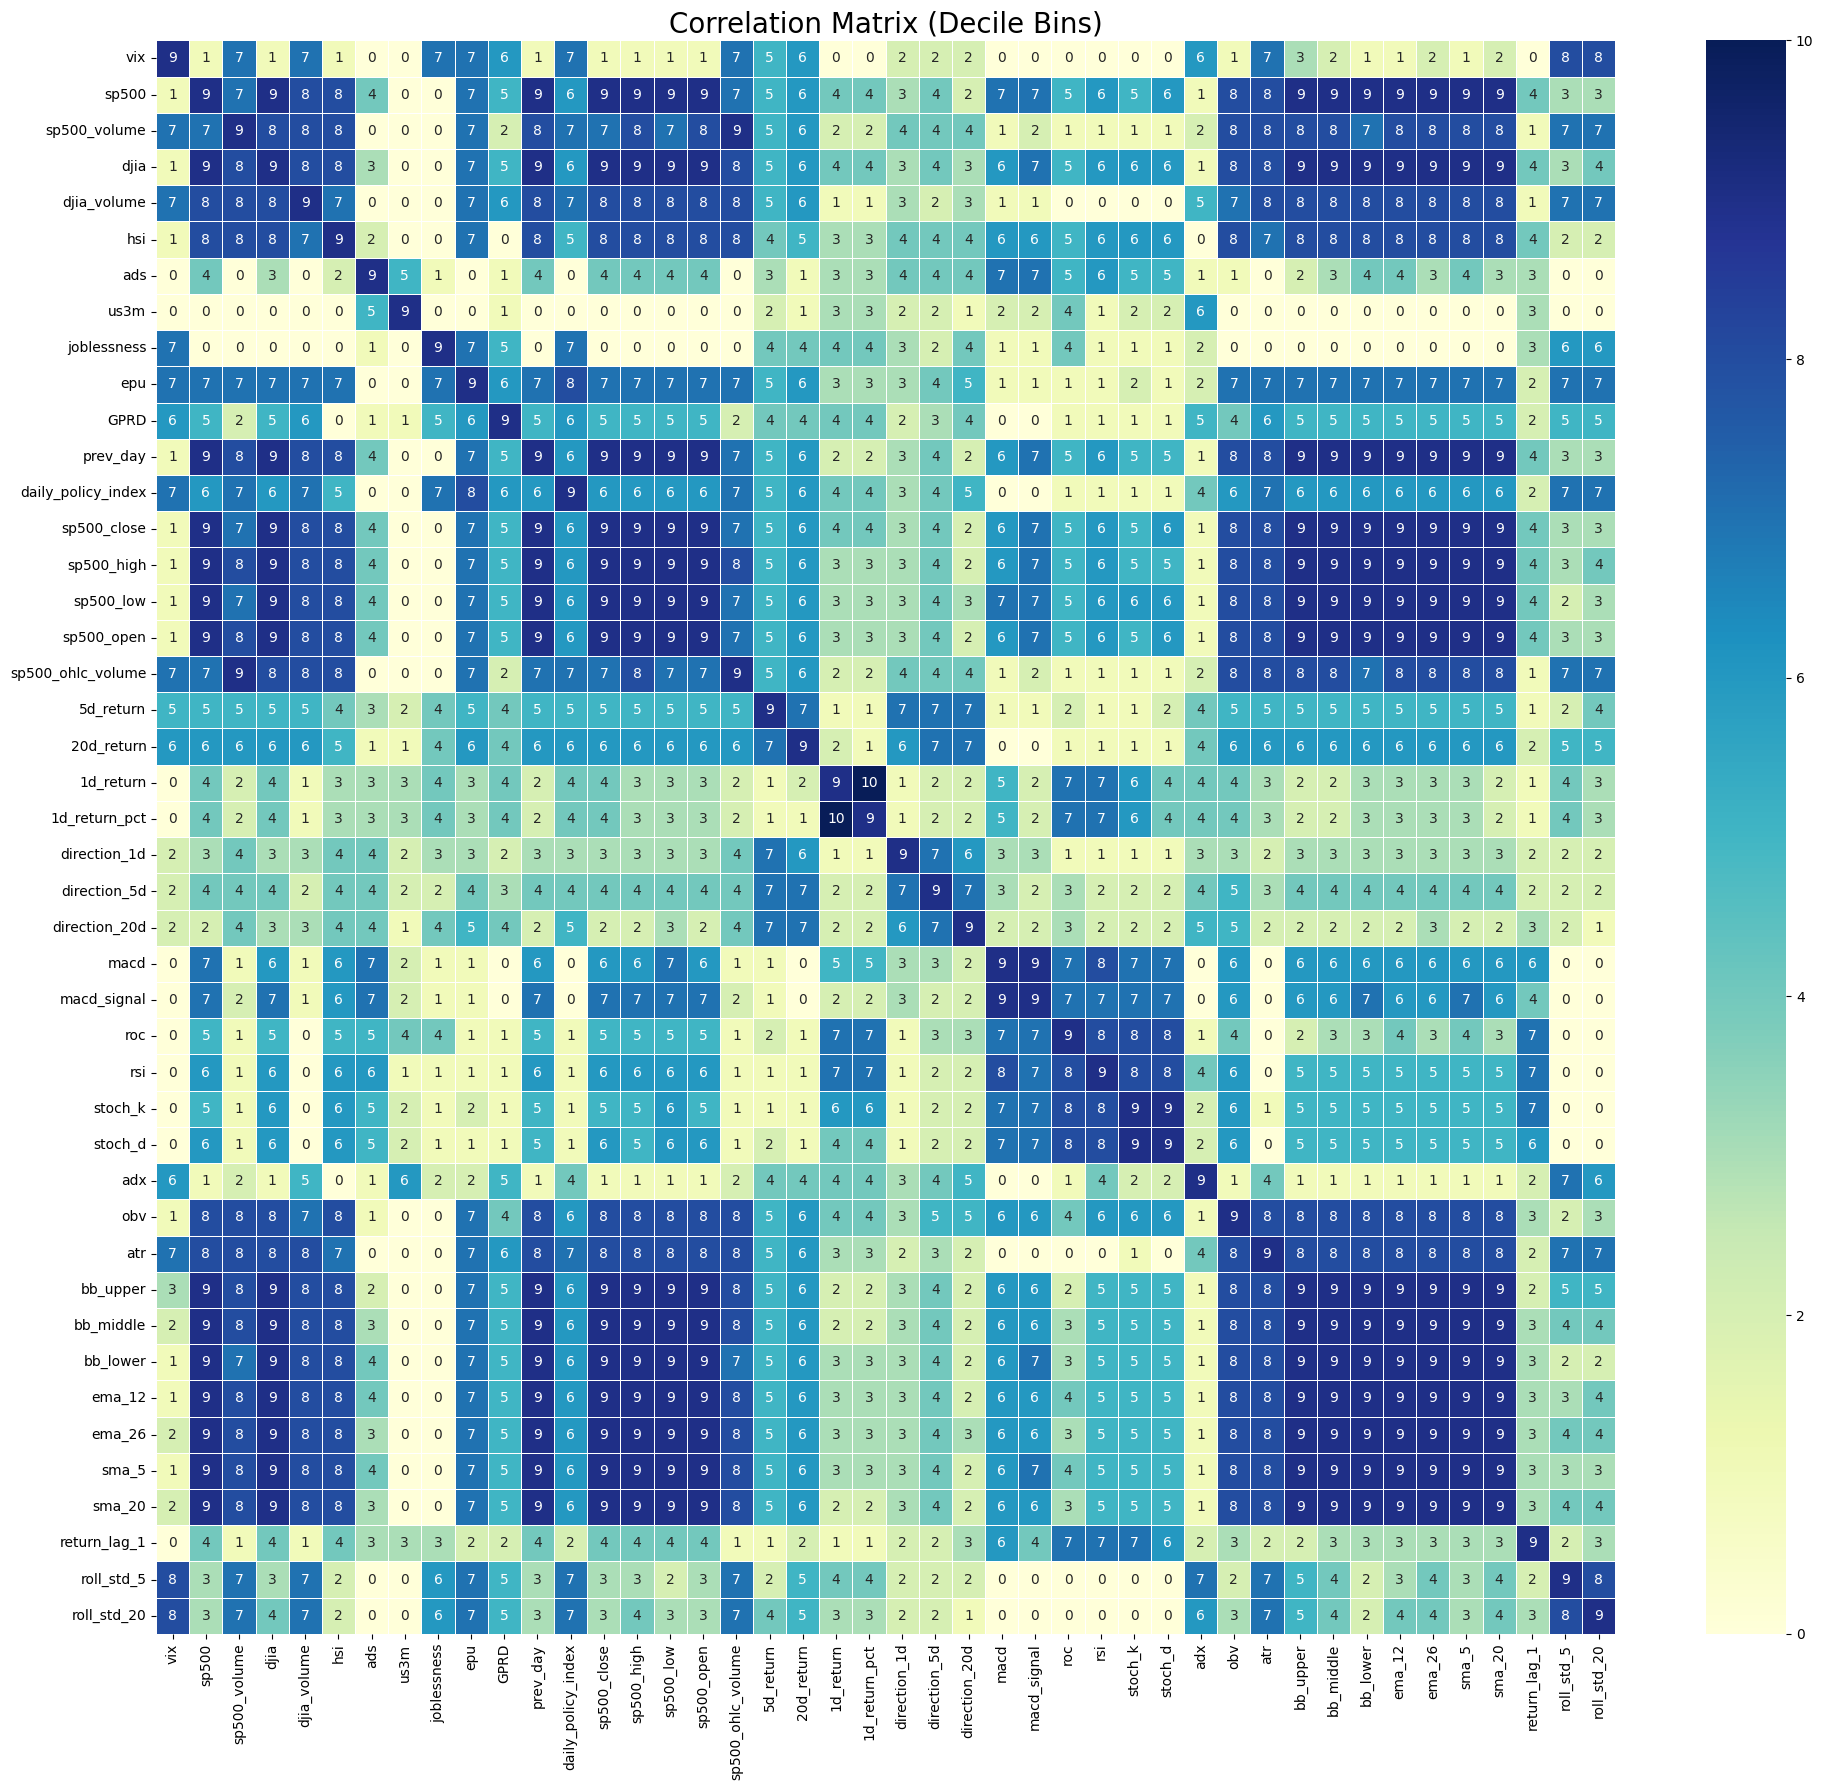

In [196]:
# get the decile for each correlation to give 0-10 heat map/correlation matrix
def assign_decile(x):
    return np.searchsorted(deciles, x, side="right") - 1


# Compute correlation matrix (numeric only)
corr_matrix = df.corr(numeric_only=True)

# Flatten and compute deciles
corr_values = corr_matrix.to_numpy().flatten()        # get the matrix to a numpy array
mask = ~np.eye(corr_matrix.shape[0], dtype=bool)      # create the identify matrix
deciles = np.percentile(corr_values[mask.flatten()], np.arange(0, 101, 10)) # get percentiles

corr_decile = corr_matrix.applymap(assign_decile)     # get the deciles

# make the heatmap of deciles
plt.figure(figsize=(20, 18))  # make figure larger
sns.heatmap(
    corr_decile,
    annot=True,
    fmt="d",
    cmap="YlGnBu",  # use yellow-green-blue since I'm colorblind
    cbar=True,
    linewidths=0.5, # add grid lines between cells
)

plt.title("Correlation Matrix (Decile Bins)", fontsize=20)

# Rotate x-axis labels for readability
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


## Visualize target variable distribution

Visualize the distribution of the target variables (1-day, 5-day, and 20-day directions) to understand the class balance.


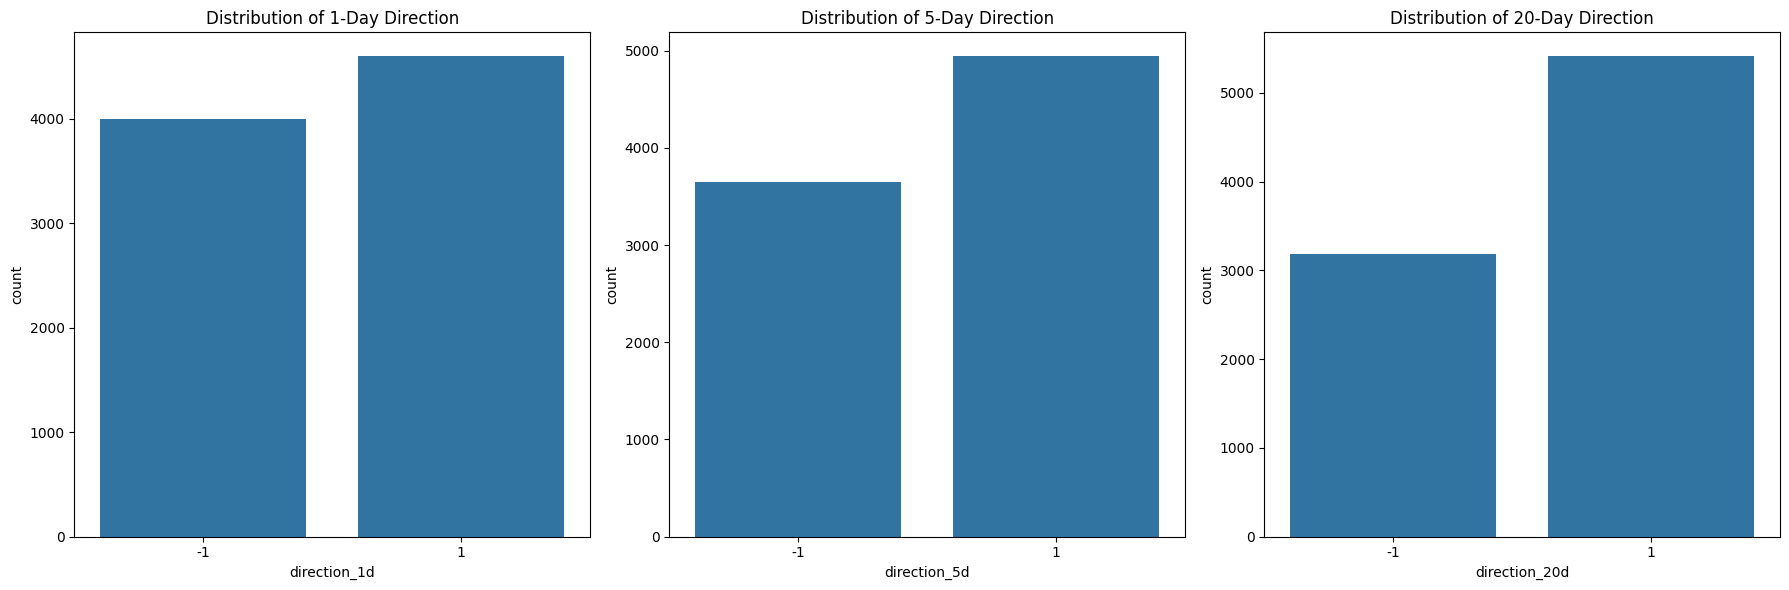

In [197]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.countplot(x='direction_1d', data=df, ax=axes[0])
axes[0].set_title('Distribution of 1-Day Direction')

sns.countplot(x='direction_5d', data=df, ax=axes[1])
axes[1].set_title('Distribution of 5-Day Direction')

sns.countplot(x='direction_20d', data=df, ax=axes[2])
axes[2].set_title('Distribution of 20-Day Direction')

plt.tight_layout()
plt.show()

I'll record the 1, 5, and 20 day class imbalance

Last round before we train, we've added rolling data so we'll do a mean imputer for the periods we don't have. We'll be missing 19 values in the 20-day rolling column, 5 rows in the 5-day rolling, and 1 value in the lagged return column. We'll impute those in place.

In [198]:
def print_missing_value_counts(df):
  # Count NaNs in any column
  print(df.isna().any(axis=1).sum())


# Get the count of missing values. Should be ~25
print_missing_value_counts(df)

# Columns to impute
cols_to_impute = ['return_lag_1', 'roll_std_5', 'roll_std_20']

# Initialize imputer to replace missing with the mean
imputer = SimpleImputer(strategy='mean')

# Fit on the missing values and transform
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

# Verify we're not missing any more
print_missing_value_counts(df)

54
54


In [199]:
print_missing_value_counts(df)
# drop rows with ANY NaN values
df = df.dropna()

# reset the index to clean up
df = df.reset_index(drop=True)
print_missing_value_counts(df)

54
0


In [200]:
# Prepare x and y for modeling
# Separate features and target
predictor_drop_columns = ['direction_1d', 'direction_5d', 'direction_20d',
                     'Date', '1d_return', '1d_return_pct', 'return_lag_1',
                     '5d_return', '20d_return',
                     'sp500', 'sp500_close']
df_input_features = df.drop(columns=predictor_drop_columns)   # predict the next day
y_basic_target = df['direction_1d']



# Feature Reduction

We'll define a basic model, use it to reduce features, do PCA,

## Define a modelling function
I will reuse a modelling function throughout my analysis to see how different transforms like PCA and column removal based on VIF change the model quality score.

In [203]:
# Function clean_params
# Purpose:
#   cleans the data type info from the params collection for printout
# Parameters:
#   params - dictionary of parameters in the random forest model
# Output:
#   dictionary with the data type names removed
def clean_params(params):
    """Convert NumPy types in params to plain Python types for clean printing."""
    def convert(v):
        if isinstance(v, (np.integer,)):
            return int(v)
        elif isinstance(v, (np.floating,)):
            return float(v)
        elif isinstance(v, (np.str_,)):
            return str(v)
        return v
    return {k: convert(v) for k, v in params.items()}

# Function do_train_rf
# Purpose:
#   Train a random forest model with random search for hyperparameter tuning
#   Report on the out-of-bag score for each randomly trained model
#   Preserve the best model for use
# Parameters:
#   X - the set of predictor features
#   y - the target feature
#   {n_models} - optional, number of models to train in the search
# Output: trained random forest model using best hyperparameters

def do_train_rf(X, y, n_models=5):
  # Define random search space
  param_space = {
      'n_estimators': np.arange(100, 500, 50),
      'max_depth': np.arange(3, 20),
      'min_samples_split': np.arange(2, 20),
      'min_samples_leaf': np.arange(1, 20),
      'max_features': ['sqrt', 'log2']
  }

  best_score = -999999    # track our best OOB score
  best_hyperparams = None # collect the best hyperparameters
  best_rf_model = None    # keep the best for later "best features" review

  for i in range(n_models):
      # Randomly sample parameters
      params = {
          'n_estimators': np.random.choice(param_space['n_estimators']),
          'max_depth': np.random.choice(param_space['max_depth']),
          'min_samples_split': np.random.choice(param_space['min_samples_split']),
          'min_samples_leaf': np.random.choice(param_space['min_samples_leaf']),
          'max_features': np.random.choice(param_space['max_features']),
          'bootstrap': True,
          'oob_score': True,
          'random_state': 17
      }

      # Train model
      rf_model = RandomForestClassifier(**params)
      rf_model.fit(X, y)

      # Compute OOB accuracy and print for each round
      oob_acc = rf_model.oob_score_
      print(f"Round {i+1}: OOB Accuracy = {oob_acc:.4f}, Params = {clean_params(params)}")

      # Track best
      if oob_acc > best_score:
          best_score = oob_acc
          best_params = params
          best_model = rf_model

  # Print best OOB score and parameters

  print("Best OOB Score:", best_score)
  print("Best Parameters:", clean_params(best_params))

  # return the best model
  return best_model



### Initial Training, Setup for Feature Reduction
I will now train using a 50-round iteration to train an initial model. The outputs of this will be used to guage the first approximation of a good model and the feature importances will be used for further input feature reduction.

In [204]:

# Call the reusable function asking for 50 iterations of search
best_rf_model = do_train_rf(df_input_features, y_basic_target, n_models =50 )

Round 1: OOB Accuracy = 0.5344, Params = {'n_estimators': 350, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 2: OOB Accuracy = 0.5347, Params = {'n_estimators': 450, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 3: OOB Accuracy = 0.5285, Params = {'n_estimators': 300, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 4: OOB Accuracy = 0.5344, Params = {'n_estimators': 250, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 5: OOB Accuracy = 0.5326, Params = {'n_estimators': 250, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': 

These scores were better than average. I'll compute the Variance Inflation Factor (VIF) to see if there is any standout multicollinearity in the features.

## Test of Multicollinearity

We'll use VIF to test for multicollinearity among columnes

In [205]:
# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = df_input_features.columns    # get column list

# For each factor, compute the VIF
vif_data['VIF'] = [variance_inflation_factor(df_input_features.values, i) for i in range(df_input_features.shape[1])]

# Sort by VIF descending. I want the most collinear first
vif_data = vif_data.sort_values('VIF', ascending=False)

print(vif_data)

               feature           VIF
31              sma_20           inf
26           bb_middle           inf
25            bb_upper  9.007199e+15
27            bb_lower  4.503600e+15
28              ema_12  1.003767e+10
29              ema_26  9.972884e+09
16                macd  3.868889e+06
30               sma_5  9.512782e+04
14          sp500_open  4.752832e+04
12          sp500_high  2.960573e+04
10            prev_day  2.450342e+04
13           sp500_low  2.105281e+04
15   sp500_ohlc_volume  1.954786e+03
1         sp500_volume  1.948412e+03
17         macd_signal  4.579301e+02
2                 djia  2.589267e+02
23                 obv  5.921885e+01
20             stoch_k  2.185651e+01
21             stoch_d  1.952435e+01
24                 atr  1.899201e+01
33         roll_std_20  1.103992e+01
0                  vix  7.635791e+00
4                  hsi  5.759746e+00
3          djia_volume  5.092741e+00
32          roll_std_5  4.488857e+00
8                  epu  3.965475e+00
1

I'll drop anything with VIF higher than 10 to remove highly collinear columns

In [206]:
# I'm setting the VIF threshold here. Typical values are 5 or 10.
vif_threshold = 10

# Prep
vif_data = pd.DataFrame()         # new df to receive vif
vif_data['feature'] = df_input_features.columns   # get the feature names for print later

# Compute VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(df_input_features.values, i) for i in range(df_input_features.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)   # Sort the df

# List features to drop
features_to_drop = vif_data[vif_data['VIF'] > vif_threshold]['feature'].tolist()

print("High multicollinearity (VIF > {}):".format(vif_threshold))
print(features_to_drop)

High multicollinearity (VIF > 10):
['sma_20', 'bb_middle', 'bb_upper', 'bb_lower', 'ema_12', 'ema_26', 'macd', 'sma_5', 'sp500_open', 'sp500_high', 'prev_day', 'sp500_low', 'sp500_ohlc_volume', 'sp500_volume', 'macd_signal', 'djia', 'obv', 'stoch_k', 'stoch_d', 'atr', 'roll_std_20']


Drop the features discovered in multicollinearity test

In [207]:
# now drop them
df_no_multicollinearity = df_input_features.drop(columns=features_to_drop)

# Train a model now without those features and measure
best_rf_model = do_train_rf(df_no_multicollinearity, y_basic_target, n_models=10)

Round 1: OOB Accuracy = 0.5322, Params = {'n_estimators': 250, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 2: OOB Accuracy = 0.5259, Params = {'n_estimators': 350, 'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 19, 'max_features': 'log2', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 3: OOB Accuracy = 0.5280, Params = {'n_estimators': 450, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 4: OOB Accuracy = 0.5280, Params = {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 5: OOB Accuracy = 0.5289, Params = {'n_estimators': 300, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'boots

My scores have not improved through multicollinear feature removal. Try PCA to see if that helps.

## Do PCA

After feature reduction based on VIF we'll also do PCA

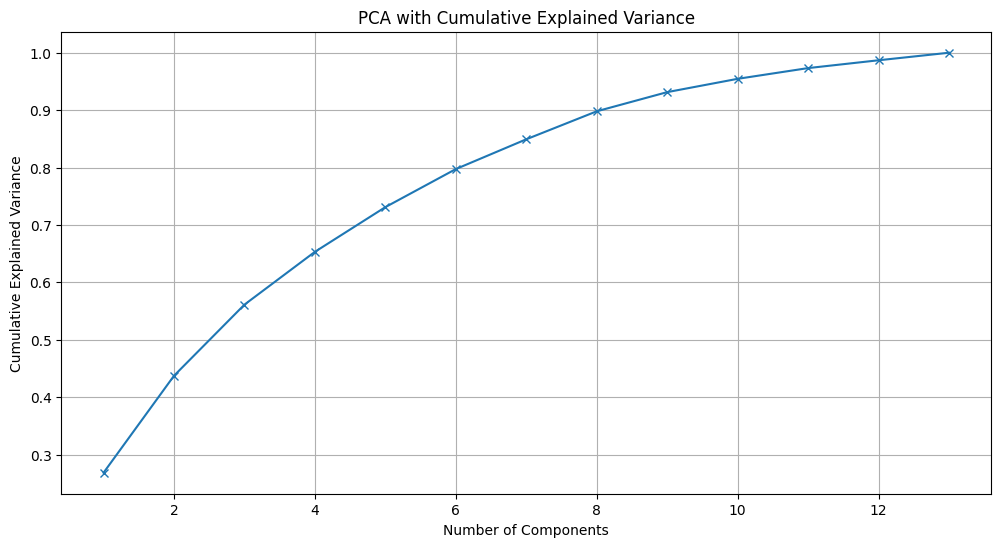

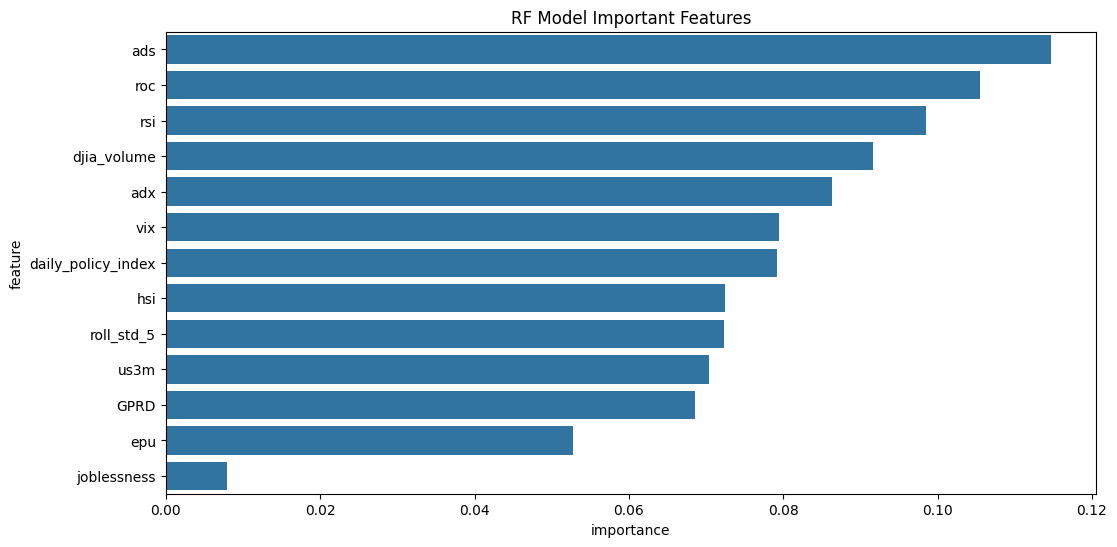

In [208]:

# Going to do PCA to analyze features
# Scale the features first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_no_multicollinearity)

# Apply PCA
pca = PCA(n_components=None, random_state=17)
X_pca = pca.fit_transform(X_scaled)

# Create a cumulative plot of the explained_variance_ratio_ values from PCA
explained_var_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(explained_var_ratio)+1), np.cumsum(explained_var_ratio), marker='x')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA with Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Create a plot fo the most important features
importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': df_no_multicollinearity.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('RF Model Important Features')
plt.show()

# I'll get the number of features that add up to 90% of the variability
#   then I'll use those to set the reduced feature set later after PCA
# Have to add 1 to ensure we capture 90 and never choose zero features
ideal_number_features = (np.cumsum(explained_var_ratio) >= 0.90).argmax() + 1


I will now make a set with only the features that collectively explain >90% of the model variance.

In [209]:

# We previously set ideal number of features in a variable in PCA.
# Use it now

# Now get the list of features I will keep
# Get feature importances and their names
feature_importances = best_rf_model.feature_importances_  # importance values
feature_names = best_rf_model.feature_names_in_           # feature names

# Sort features by importance descending
sorted_importance = np.argsort(feature_importances)[::-1]

# Limit to ideal_number_features
top_features = sorted_importance[:ideal_number_features]

# Get feature names into list
features_to_preserve = feature_names[top_features]

print(f"Features to preserve: {features_to_preserve}")

# Make reduced set of features and train new model
X_feature_reduced = df_input_features[features_to_preserve]

# reuse our RF model training function
rf_model = do_train_rf(X_feature_reduced, y_basic_target, n_models=5)

Features to preserve: ['ads' 'roc' 'rsi' 'djia_volume' 'adx' 'vix' 'daily_policy_index' 'hsi'
 'roll_std_5']
Round 1: OOB Accuracy = 0.5333, Params = {'n_estimators': 400, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'log2', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 2: OOB Accuracy = 0.5332, Params = {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 18, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 3: OOB Accuracy = 0.5305, Params = {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 14, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 4: OOB Accuracy = 0.5315, Params = {'n_estimators': 450, 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': 'log2', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 5: OOB Accuracy = 0.5274, Params = {'n_estimat

## Test Post-Feature Reduction

In [210]:
# I'll do the 20-day first to see the most-likely high quality model
y_basic_target = df['direction_20d']
rf_model = do_train_rf(X_feature_reduced, y_basic_target, n_models=5)

# We'll do the 5 day now and use that for the rest of our analysis
y_basic_target = df['direction_5d']
# we're doing the 5 day. we need to remove the 5d rolling std from the measures
X_feature_reduced = X_feature_reduced.drop(columns=['roll_std_5'], errors='ignore')
rf_model = do_train_rf(X_feature_reduced, y_basic_target, n_models=5)
len(X_feature_reduced)

Round 1: OOB Accuracy = 0.7503, Params = {'n_estimators': 250, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 2: OOB Accuracy = 0.8262, Params = {'n_estimators': 400, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 3: OOB Accuracy = 0.7133, Params = {'n_estimators': 350, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 4: OOB Accuracy = 0.7616, Params = {'n_estimators': 200, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 17, 'max_features': 'log2', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 5: OOB Accuracy = 0.6454, Params = {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap

8543

The 20-day prediction scores higher than the 5-day, which is in line with the research references I reviewed. The 1-day is not much better than chance, which is also in line with the references.

## Final Clean up

Clean up any remaining missing dates. Delete instead of imputing.

In [211]:

print_missing_value_counts(df)

# drop rows with ANY NaN values
df = df.dropna()

# reset the index to clean up
df = df.reset_index(drop=True)

# verify
print_missing_value_counts(df)

0
0


# Time Series Analysis and Augmentation

We'll explore time series optimal lags and add factors to the dataset based on them. I will then determine if these are significant contributors to the model in predicting the 5-day direction of the market.

## Basic time series to select lags

### Test stationarity

In [212]:
# Drop missing values
close_no_na = df['sp500_close'].dropna()

# Remove trend to get stationarity (first difference)
close_first_diff = close_no_na.diff().dropna()

# do ADF test for stationarity
adf_result = adfuller(close_first_diff)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
for key, value in adf_result[4].items():
    print(f'Critical Value ({key}): {value}')

if adf_result[1] < 0.05:
    print("Series is likely stationary")
else:
    print("Series is likely non-stationary")

ADF Statistic: -16.31201152904845
p-value: 3.189170501613244e-29
Critical Value (1%): -3.4311191093193036
Critical Value (5%): -2.8618798939892236
Critical Value (10%): -2.5669509206674084
Series is likely stationary


## Train OLS Model and plot the ACF/PACF

We'll train a basic Ordinary Least Squares model and view the ACF/PACF to determine optimal lags visually.

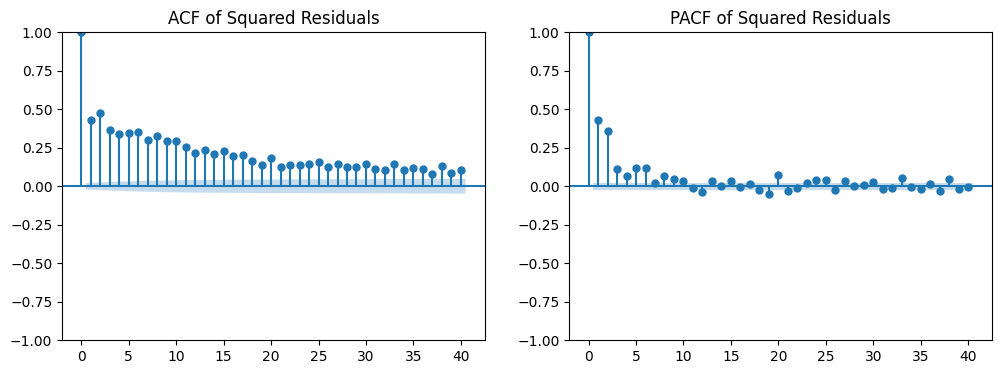

In [213]:
# fit basic regression (OLS)
X = sm.add_constant(np.ones(len(close_first_diff)))
ols_model = sm.OLS(close_first_diff.values, X).fit()
squared_resid = ols_model.resid**2  # need squared residuals for ACF/PACF

# Plot ACF and PACF of squared residuals
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(squared_resid, lags=40, ax=plt.gca())
plt.title('ACF of Squared Residuals')

plt.subplot(1,2,2)
plot_pacf(squared_resid, lags=40, ax=plt.gca())
plt.title('PACF of Squared Residuals')
plt.show()

## AIC/BIC Measures of Best Model

Both measure optimal models but BIC penalizes for complexity.

In [214]:

# ARCH lag selection
max_lag = 20
aic_list, bic_list = [], []

for p in range(1, max_lag + 1):
    am = arch_model(close_first_diff, vol='ARCH', p=p, o=0, q=0, dist='normal', rescale=True)
    res = am.fit(disp='off')
    aic_list.append(res.aic)
    bic_list.append(res.bic)

# Compile results
arch_lag_selection = pd.DataFrame({
    'lag': range(1, max_lag + 1),
    'AIC': aic_list,
    'BIC': bic_list
})

# Display table
print(arch_lag_selection)

# Optimal lag
optimal_lag_aic = arch_lag_selection.loc[arch_lag_selection['AIC'].idxmin(), 'lag']
optimal_lag_bic = arch_lag_selection.loc[arch_lag_selection['BIC'].idxmin(), 'lag']
print(f"Best ARCH lag (AIC): {optimal_lag_aic}")
print(f"Best ARCH lag (BIC): {optimal_lag_bic}")

/tmp/ipython-input-1132820473.py:7: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')
/tmp/ipython-input-1132820473.py:7: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')
/tmp/ipython-input-1132820473.py:7: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  res = am.fit(disp='off')


    lag           AIC           BIC
0     1  72982.910162  73004.068413
1     2  70478.665590  70506.876592
2     3  69154.888388  69190.152140
3     4  68353.638583  68395.955086
4     5  67840.403880  67889.773133
5     6  67595.862417  67652.284421
6     7  67368.064742  67431.539496
7     8  67100.550802  67171.078306
8     9  66901.996984  66979.577239
9    10  66811.976884  66896.609890
10   11  66735.130303  66826.816059
11   12  66709.261717  66808.000224
12   13  66673.779205  66779.570461
13   14  66640.987815  66753.831823
14   15  66626.232660  66746.129418
15   16  66570.275404  66697.224912
16   17  66534.367256  66668.369514
17   18  66524.613832  66665.668841
18   19  66479.156036  66627.263795
19   20  66469.313268  66624.473778
Best ARCH lag (AIC): 20
Best ARCH lag (BIC): 20


ARCH model specified lag at max lag, which is too high. Move would move to GARCH(1,1) but we'll just use the EMA and SMA indicators already in the features.

## Add Columns Based on Time Series

The time series indicated an effect at 1-day lag that diminished quickly after this.

In [215]:
# make a 1 day lag like a VAR model
df[f'return_lag_1'] = df['1d_return'].shift(1) # acf+pacf said 1 day lag is potenntially relevant

# Add to potentially overcome clustering of volatility metrics
df['roll_std_5'] = df['1d_return'].rolling(5).std()
df['roll_std_20'] = df['1d_return'].rolling(20).std()


In [216]:
df.columns

Index(['Date', 'vix', 'sp500', 'sp500_volume', 'djia', 'djia_volume', 'hsi',
       'ads', 'us3m', 'joblessness', 'epu', 'GPRD', 'prev_day',
       'daily_policy_index', 'sp500_close', 'sp500_high', 'sp500_low',
       'sp500_open', 'sp500_ohlc_volume', '5d_return', '20d_return',
       '1d_return', '1d_return_pct', 'direction_1d', 'direction_5d',
       'direction_20d', 'macd', 'macd_signal', 'roc', 'rsi', 'stoch_k',
       'stoch_d', 'adx', 'obv', 'atr', 'bb_upper', 'bb_middle', 'bb_lower',
       'ema_12', 'ema_26', 'sma_5', 'sma_20', 'return_lag_1', 'roll_std_5',
       'roll_std_20'],
      dtype='object')

AIC and BIC indicate the lag of 1 is most useful but the values drop off quickly potentially indicating volatility is making ARCH model lag less useful. We have already selected a feature for the return at lag=1. This feature was not determined to be a significant predictor in the test model, PCA, or multicollinearity studies.

# Class balancing
Our 1, 5, and 20 day up and down indicator bar charts above indicated that we have more samples in the "up" direction with the imbalance increasing over time. I will improve the 5-day with SMOTE to resample and rebalance the classes then train and test a new  model.

In [217]:
smote = SMOTE(random_state=17)                        # init

# at this point x and y are the 5-day direction with the input feature 5 day rolling std removed
X_balanced, y_balanced = smote.fit_resample(X_feature_reduced, y_basic_target)

rf_model = do_train_rf(X_balanced, y_balanced, n_models=5)

Round 1: OOB Accuracy = 0.6973, Params = {'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 2: OOB Accuracy = 0.6694, Params = {'n_estimators': 250, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 3: OOB Accuracy = 0.7159, Params = {'n_estimators': 150, 'max_depth': 19, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 4: OOB Accuracy = 0.6782, Params = {'n_estimators': 400, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 5: OOB Accuracy = 0.6722, Params = {'n_estimators': 400, 'max_depth': 10, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstra

The 5-day class counts for the S&P500 being up or down

In [218]:

counts = Counter(y_basic_target)
print("Class counts for 20-day pricing being up or down")
print(f"Up (1): {counts.get(1, 0)} | Down (-1): {counts.get(-1, 0)}")

Class counts for 20-day pricing being up or down
Up (1): 4921 | Down (-1): 3622


The same class counts after rebalancing:

In [219]:
X_balanced, y_balanced = smote.fit_resample(X_balanced, y_balanced)
counts = Counter(y_balanced)
print(f"Up (1): {counts.get(1, 0)} | Down (-1): {counts.get(-1, 0)}")

Up (1): 4921 | Down (-1): 4921


### Final Model Build

In [220]:
# train the final model with 50 trees
rf_model = do_train_rf(X_balanced, y_balanced, n_models=50)


Round 1: OOB Accuracy = 0.5723, Params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 2: OOB Accuracy = 0.6897, Params = {'n_estimators': 300, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 3: OOB Accuracy = 0.6446, Params = {'n_estimators': 250, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 4: OOB Accuracy = 0.7199, Params = {'n_estimators': 200, 'max_depth': 16, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True, 'oob_score': True, 'random_state': 17}
Round 5: OOB Accuracy = 0.5690, Params = {'n_estimators': 150, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt', 'bootstrap'

# Prediction
Code a method that will be used to predict the class 5 days in the future and the probability of that prediction. This seems to make the most of the prediction power of the models. The 1-day is better than chance, but just a bit. The 20-day is far enough in the future and the class weighting so far in favor of the positive/up direction that it is likely less useful than the 5 day. The 5-day direction model is ~75% accuracy and the 20-day model is ~85%. The lower accuracy is likely acceptable for short-term market direction trading.

## Prediction Dataframe Requirements
We only need a subset of variables to do prediction. The columns must match the model.

In [221]:
X_balanced.columns

Index(['ads', 'roc', 'rsi', 'djia_volume', 'adx', 'vix', 'daily_policy_index',
       'hsi'],
      dtype='object')

In [222]:

# Function do_predict
# Purpose:
#   use the best trained model to do prediction
# Parameters:
#   model - model to use for prediction
#   df_input_features - dataframe with features to use to predict the outcome for input data
def do_predict(model, df_input_features):
  y_pred = model.predict(df_input_features)        # class
  y_prob = model.predict_proba(df_input_features)  # probability
  return y_pred, y_prob

In [223]:
# Get your feature names from the balanced dataset
balanced_cols = X_balanced.columns.tolist()

# Select those columns + direction_5d + Date from the full dataframe
cols_to_get = ['Date'] + balanced_cols +  ['sp500_close']
len(df)
# Extract those columns
df_predict = df[cols_to_get]
len(df_predict)

# Prepare X for prediction (drop Date and target)
X_recent = df_predict[balanced_cols]
len(X_recent)
# Predict next 20-day direction
preds = rf_model.predict(X_recent)

# Combine results
df_predict['Pred_dir_5d'] = preds
#print(df_predict[['Date', 'direction_5d', 'Pred_dir_5d', '5d_return', 'sp500_close']])




In [224]:
print(df_predict.columns)
len( df_predict)

Index(['Date', 'ads', 'roc', 'rsi', 'djia_volume', 'adx', 'vix',
       'daily_policy_index', 'hsi', 'sp500_close', 'Pred_dir_5d'],
      dtype='object')


8543

# Model Profit Simulation

This compares two scenarios, the first being the use of this model with a fraction of the balance invested in each round of purchase, and the second being a buy at the beginning of the dataset and selling at the end.

In both cases the initial portfolio balance is $10,000. The fraction to invest is 50% and can be varied.

In [225]:
# --- Parameters ---
starting_balance = 10000.0
fraction_to_invest = 0.5  # 50% of current cash used per buy, can be 0.0 to 1.0

cash = starting_balance
position = 0
portfolio_values = []
active = False

for i in range(len(df_predict)):
    price = df_predict.loc[i, 'sp500_close']
    pred_curr = df_predict.loc[i, 'Pred_dir_5d']
    pred_prev = df_predict.loc[i-1, 'Pred_dir_5d'] if i > 0 else 0

    # Wait for first buy
    if not active:                  # handle the startup state
        if pred_curr == 1:          # if we should buy
            active = True           # we are now in a "buy" state
            # Buy fraction of cash
            invest_amount = cash * fraction_to_invest # set how much to invest
            position = invest_amount / price          # set how many shares we can get
            cash -= invest_amount                     # reduce the portfolio balance
        portfolio_values.append(cash + position * price)  # set the current balance
        continue

    # Buy signal: -1 -> 1
    if pred_prev == -1 and pred_curr == 1:            # moved from no buy to buy signal
        invest_amount = cash * fraction_to_invest     # set the investment amount
        if invest_amount > 0:                         # if we have money
            position += invest_amount / price         # set number of shares
            cash -= invest_amount                     # reduce the portfolio

    # Sell signal: 1 -> -1                            # moved from buy to sell
    elif pred_prev == 1 and pred_curr == -1 and position > 0: # if we're in and should sell
        # Sell all held shares
        cash += position * price                      # calculate new balance
        position = 0

    portfolio_values.append(cash + position * price)  # append the balance

df_predict['portfolio_value'] = portfolio_values

# --- Summary ---
final_value = df_predict['portfolio_value'].iloc[-1]          # ending value
total_return = (final_value - starting_balance) / starting_balance * 100  # portfolio return

# Buy and hold meaning buy at the start of the dataset period and sell at the end
buy_and_hold_value = starting_balance / df_predict['sp500_close'].iloc[0] * df_predict['sp500_close'].iloc[-1]
buy_and_hold_return = (buy_and_hold_value - starting_balance) / starting_balance * 100

print(f"Final portfolio value: ${final_value:,.2f}, return: {total_return:.2f}%")
print(f"Buy and hold value: ${buy_and_hold_value:,.2f}, return: {buy_and_hold_return:.2f}%")


Final portfolio value: $20,554,073.22, return: 205440.73%
Buy and hold value: $145,764.81, return: 1357.65%


# Post-processing Use

The following section would make up parts of the online service that could be used to serve this model in a web application. We will save a model to disk, load it back from disk, and predict today's direction signal.

I will use Pickle to make a binary compressed version of the model for speed of reading and writing and to make the model small on disk. The model won't be large anyway but it's good practice.

Change the disk save/load locations to change how to persist the serialized model.

## Post-Processing Imports

In [226]:
import pickle

## Save Model

Serialize the model for version control, adding to containerized web services, and backup. Note that in Colab this is a temporary file but other environments may be able to persist the data locally.

In [227]:
# Serialize the file by pickling it to disk
file_name = "trained_random_forest.pkl"
try:
  with open(file_name, 'wb') as __file:
      pickle.dump(rf_model, __file)
      print(f"File saved locally as {file_name}")
except Exception as e:
  print(e)


File saved locally as trained_random_forest.pkl


In [228]:
print(df_predict.columns)

Index(['Date', 'ads', 'roc', 'rsi', 'djia_volume', 'adx', 'vix',
       'daily_policy_index', 'hsi', 'sp500_close', 'Pred_dir_5d',
       'portfolio_value'],
      dtype='object')


## Load Trained Model

This would be part of a containerized production service in which a model would be added behind a Flask REST service to do the prediction. This portion would load the model into memory for use within the REST API code.

In [229]:
# Read the model back from disk and it's ready for use
file_name = "trained_random_forest.pkl"
try:
  with open(file_name, 'rb') as __file:
    rf_model = pickle.load(__file)
    print(f"File read from local {file_name}")
except Exception as e:
  print(e)

File read from local trained_random_forest.pkl


## Predict signal for today

To predict for today we need get the VIX, S&P, Dow Jones, Hang Seng from Yahoo; ADS from the Philadelphia Fed; and the EPU from policyuncertainty.com

We'll call the URLs or APIs, construct a row for today, and determine whether or not we should be in the market today based on the 5-day prediction.

### Collect Data

Get the Yahoo values

In [230]:
# We require 15 days of data to be able to construct the indicators from the pricing

# --- Parameters ---
tickers = {
    'VIX': '^VIX',
    'SP500': '^GSPC',
    'DJIA': '^DJI',
    'HSI': '^HSI'
}

# Need 15 dates to get both roc and rsi but we'll only use the last row
dates = pd.date_range(end=datetime.now(), periods=15).to_pydatetime().tolist()

# Container for all rows
rows = []

for target_date in dates:
    start_date = (target_date - timedelta(days=3)).strftime('%Y-%m-%d')
    end_date = (target_date + timedelta(days=3)).strftime('%Y-%m-%d')

    data = {'Date': target_date.strftime('%Y-%m-%d')}
    for name, ticker in tickers.items():
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if not df.empty:
            # Find the row closest to the target_date (use last available)
            ticker_date = df.index[-1]
            data[f'{name}_Close'] = float(df['Close'].iloc[-1])
            data[f'{name}_High'] = float(df['High'].iloc[-1])
            data[f'{name}_Low'] = float(df['Low'].iloc[-1])
            data[f'{name}_Volume'] = float(df['Volume'].iloc[-1]) if 'Volume' in df.columns else 0.0
        else:
            # Fill missing ticker data with NaNs
            data[f'{name}_Close'] = None
            data[f'{name}_High'] = None
            data[f'{name}_Low'] = None
            data[f'{name}_Volume'] = None
    rows.append(data)

# Combine all rows
df_all = pd.DataFrame(rows)

# Rename columns for consistency
df_all = df_all.rename(columns={
    'VIX_Close': 'vix',
    'SP500_Close': 'sp500_close',
    'SP500_High': 'sp500_high',
    'SP500_Low': 'sp500_low',
    'DJIA_Close': 'djia_close',
    'DJIA_High': 'djia_high',
    'DJIA_Volume': 'djia_volume',
    'HSI_Close': 'hsi'
})

# Add indicators (computed across the series)
df_all['roc'] = ta.momentum.roc(close=df_all['sp500_close'])
df_all['rsi'] = ta.rsi(df_all['sp500_close'], length=14)
df_all['adx'] = ta.adx(df_all['sp500_high'], df_all['sp500_low'], df_all['sp500_close'], timeperiod=14)['ADX_14']


print(df_all)


          Date        vix   VIX_High    VIX_Low  VIX_Volume  sp500_close  \
0   2025-10-12  20.809999  22.940001  19.180000         0.0  6644.310059   
1   2025-10-13  20.639999  22.440001  19.110001         0.0  6671.060059   
2   2025-10-14  25.309999  25.430000  19.850000         0.0  6629.069824   
3   2025-10-15  20.780001  28.990000  20.730000         0.0  6664.009766   
4   2025-10-16  20.780001  28.990000  20.730000         0.0  6664.009766   
5   2025-10-17  20.780001  28.990000  20.730000         0.0  6664.009766   
6   2025-10-18  18.230000  21.020000  18.230000         0.0  6735.129883   
7   2025-10-19  17.870001  18.889999  17.400000         0.0  6735.350098   
8   2025-10-20  18.600000  21.010000  17.730000         0.0  6699.399902   
9   2025-10-21  17.299999  19.350000  17.080000         0.0  6738.439941   
10  2025-10-22  16.370001  17.219999  16.020000         0.0  6791.689941   
11  2025-10-23  16.370001  17.219999  16.020000         0.0  6791.689941   
12  2025-10-

Next we get the current business climate info from the Philadelphia Fed

In [231]:


# --- Get ADS index from the Philadelphia Fed ---
ads_url = "https://www.philadelphiafed.org/-/media/FRBP/Assets/Surveys-And-Data/ads/ADS_Index_Most_Current_Vintage.xlsx?la=en&sc_lang=en&hash=C8661B0DEA6B9436ECDCBEFC187B7997"

ads_df = pd.read_excel(ads_url, header=None)

# Clean: remove header rows and non-numeric entries in column B
ads_df = ads_df[pd.to_numeric(ads_df[1], errors='coerce').notna()]

# Extract the most recent non-null value from column B
latest_ads_value = ads_df[1].dropna().iloc[-1]

# --- Assign to the last row of df_all ---
df_all.loc[df_all.index[-1], 'ads'] = latest_ads_value

print(df_all.tail(3))


          Date        vix   VIX_High  VIX_Low  VIX_Volume  sp500_close  \
12  2025-10-24  16.370001  17.219999    16.02         0.0  6791.689941   
13  2025-10-25  16.370001  17.219999    16.02         0.0  6791.689941   
14  2025-10-26  16.370001  17.219999    16.02         0.0  6791.689941   

     sp500_high    sp500_low  SP500_Volume    djia_close  ...      DJIA_Low  \
12  6807.109863  6772.069824  5.058220e+09  47207.121094  ...  46811.511719   
13  6807.109863  6772.069824  5.058220e+09  47207.121094  ...  46811.511719   
14  6807.109863  6772.069824  5.058220e+09  47207.121094  ...  46811.511719   

    djia_volume           hsi      HSI_High       HSI_Low    HSI_Volume  \
12  403500000.0  26160.150391  26239.960938  26063.990234  2.592100e+09   
13  403500000.0  26160.150391  26239.960938  26063.990234  2.592100e+09   
14  403500000.0  26160.150391  26239.960938  26063.990234  2.592100e+09   

         roc        rsi        adx       ads  
12  2.453136  86.771373        NaN    

Finally we get the latest economic policy uncertainty

In [232]:
df_epu = get_epu_df()
df_epu.tail()
# Extract the most recent non-null value from column B
latest_epu_value = df_epu['daily_policy_index'].dropna().iloc[-1]

# --- Assign to the last row of df_all. It's called epu in that dataframe ---
df_all.loc[df_all.index[-1], 'daily_policy_index'] = latest_epu_value
df_all.loc[df_all.index[-1], 'epu'] = latest_epu_value
df_all.tail()

,Date,vix,VIX_High,VIX_Low,VIX_Volume,sp500_close,sp500_high,sp500_low,SP500_Volume,djia_close,...,hsi,HSI_High,HSI_Low,HSI_Volume,roc,rsi,adx,ads,daily_policy_index,epu
10,2025-10-22,16.370001,17.219999,16.02,0.0,6791.689941,6807.109863,6772.069824,5.058220e+09,47207.121094,...,26160.150391,26239.960938,26063.990234,2.592100e+09,2.218137,86.771373,NaN,NaN,NaN,NaN
11,2025-10-23,16.370001,17.219999,16.02,0.0,6791.689941,6807.109863,6772.069824,5.058220e+09,47207.121094,...,26160.150391,26239.960938,26063.990234,2.592100e+09,1.808257,86.771373,NaN,NaN,NaN,NaN
12,2025-10-24,16.370001,17.219999,16.02,0.0,6791.689941,6807.109863,6772.069824,5.058220e+09,47207.121094,...,26160.150391,26239.960938,26063.990234,2.592100e+09,2.453136,86.771373,NaN,NaN,NaN,NaN
13,2025-10-25,16.370001,17.219999,16.02,0.0,6791.689941,6807.109863,6772.069824,5.058220e+09,47207.121094,...,26160.150391,26239.960938,26063.990234,2.592100e+09,1.915966,86.771373,73.056703,NaN,NaN,NaN
14,2025-10-26,16.370001,17.219999,16.02,0.0,6791.689941,6807.109863,6772.069824,5.058220e+09,47207.121094,...,26160.150391,26239.960938,26063.990234,2.592100e+09,1.915966,86.771373,73.056703,0.023866,203.13,203.13


Construct a dataframe that looks like our model so we can predict today's position.

### Build Input and Give Recommendation

In [235]:
today_inputs = df_all.tail(1)[[
    'roc', 'ads', 'rsi', 'adx',
    'djia_volume', 'daily_policy_index',
    'vix', 'hsi'
]].reset_index(drop=True)

print(today_inputs)



        roc       ads        rsi        adx  djia_volume  daily_policy_index  \
0  1.915966  0.023866  86.771373  73.056703  403500000.0              203.13   

         vix           hsi  
0  16.370001  26160.150391  


Sanity check of model features vs what we've constructed. They must be in the same order.

In [236]:
# model features
print("The columns must be exactly:")
print(rf_model.feature_names_in_)

print("")
print("Input columns actually are:")
print(today_inputs.columns)

print("Reordering...")
model_order = rf_model.feature_names_in_

# Reassign the DataFrame with the new column order
today_inputs = today_inputs[model_order]

print("")
print("Input columns now are:")
print(today_inputs.columns)

The columns must be exactly:
['ads' 'roc' 'rsi' 'djia_volume' 'adx' 'vix' 'daily_policy_index' 'hsi']

Input columns actually are:
Index(['roc', 'ads', 'rsi', 'adx', 'djia_volume', 'daily_policy_index', 'vix',
       'hsi'],
      dtype='object')
Reordering...

Input columns now are:
Index(['ads', 'roc', 'rsi', 'djia_volume', 'adx', 'vix', 'daily_policy_index',
       'hsi'],
      dtype='object')


In [237]:
# Predict whether we should be buying or selling (establish/maintain or sell our positions)
preds = rf_model.predict(today_inputs)

# Output final determination
if preds[0] == -1:
    print("Should be out of or close positions")
elif preds[0] == 1:
    print("Buy or maintain positions")


Should be out of or close positions
